In [1]:
import pandas as pd 
import requests 
from urllib.parse import urlencode 
from scipy.stats import chi2_contingency, ttest_ind
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
groups_public_key = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
group_add_public_key = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_public_key = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_public_key = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

создание функции для загрузки csv-файлов из Яндекс.Диска

In [3]:
def download_csv(public_key):
    
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    return download_url

загрузка всех необходимых файлов

In [4]:
groups_df = pd.read_csv(download_csv(groups_public_key), sep=';')
group_add_df = pd.read_csv(download_csv(group_add_public_key))
active_studs_df = pd.read_csv(download_csv(active_studs_public_key))
checks_df = pd.read_csv(download_csv(checks_public_key), sep=';')

объединение основной таблицы с пользователями, разделенными на группы, и дополнительной

In [5]:
groups_df_updated = pd.concat([groups_df, group_add_df])

проверка данных на согласованность и логическую непротиворечивость: для этого проверяю данные каждой таблицы на наличе пропусков, дубликатов и количество пользователей в каждой из таблиц и групп

In [6]:
groups_df_updated.isna().sum()

id     0
grp    0
dtype: int64

In [7]:
active_studs_df.isna().sum()

student_id    0
dtype: int64

In [8]:
checks_df.isna().sum()

student_id    0
rev           0
dtype: int64

ни в отдой из таблиц нет пропусков

In [9]:
groups_df_updated.duplicated().sum()

0

In [10]:
active_studs_df.duplicated().sum()

0

In [11]:
checks_df.duplicated().sum()

0

повторяющихся значений также нет

In [12]:
groups_df_updated.shape

(74576, 2)

In [13]:
active_studs_df.shape

(8341, 1)

In [14]:
checks_df.shape

(541, 2)

Количество данных логически верно: наибольшее количество пользователей, активных пользователей меньше (т.е. пользователей, которые зашли на платформу в дни проведения эксперимента), пользователей, совершивших покупку, еще меньше.<br/>  На основе этих данных видится целесообразным проверить конверсию в платящих пользователей в каждой из групп (целевой и контрольной). Во внимание будут браться только те пользователи, которые посетили сайт в дни проведения эксперимента. <br/> Кроме того, имея данные о размере чека, можно оценить успешность эксперимента, сравнив средний доход на одного платящего пользователя.<br/><br/>**Выбранные метрики для оценки успешности эксперимента:<br/> CR в оплату,  <br/> ARPPU.**

количество пользователей в контролькой и экспериментальной группах

In [15]:
groups_df_updated.grp.value_counts()

B    59883
A    14693
Name: grp, dtype: int64

объединение таблицы с активными пользователями с таблицей о принадлежности пользователя к контрольной или экспериментальной группе и таблицы с информацией об оплатах пользователей с основной

In [16]:
active_studs_df = active_studs_df.rename(columns={'student_id':'id'})
checks_df = checks_df.rename(columns={'student_id':'id'})

In [17]:
active_studs_groups_df = active_studs_df.merge(groups_df_updated, how='left', on='id') 
#использую left-join, чтобы проверить, что нет активных пользователей, которых нет в основной таблице со всеми пользователями

In [18]:
active_studs_groups_df.isna().sum()

id     0
grp    0
dtype: int64

In [19]:
active_studs_groups_df.shape

(8341, 2)

In [20]:
checks_active_df = checks_df.merge(active_studs_groups_df, how='left', on='id')
#использую left-join, чтобы проверить, есть ли пользователи, которые совершили оплату в дни проведения эксперимента, 
# но не присутствуют в таблице о пользователях, которые зашли на платформу в дни проведения эксперимента

In [21]:
checks_active_df.head()

,id,rev,grp
0,1627,990.0,A
1,3185,690.0,NaN
2,25973,690.0,NaN
3,26280,690.0,NaN
4,100300,990.0,B


In [22]:
checks_active_df.isna().sum()

id       0
rev      0
grp    149
dtype: int64

In [23]:
checks_active_df.shape

(541, 3)

149 пользователей совершили оплату в дни проведения эксперимента, но не присутствуют в таблице о пользователях, которые зашли на платформу в дни проведения эксперимента. Возможно, оплата была произведена не на сайте (звонок/смс/другой способ) или автоматическим списанием. Из-за того, что новая механика оплаты была введена на сайте, то пользователи, которые не заходили на платформу не могли ее оценить и не будут учитываться при расчете метрик.

In [35]:
checks_active_df = checks_active_df.dropna()
#оставляю только тех пользователей, которые совершили оплату и заходили на платформу в день эксперимента

In [34]:
checks_active_df.shape

(392, 3)

подсчитываю общее количество активных пользователей и пользовтелей, которые произвели оплату, и общий доход в каждой группе

In [51]:
total_active_per_group = active_studs_groups_df.groupby('grp', as_index=False)\
                        .agg({'id':'count'}).rename(columns={'id': 'active_users'})
total_active_per_group

,grp,active_users
0,A,1538
1,B,6803


In [37]:
total_paying_per_group = checks_active_df.groupby('grp', as_index=False)\
                        .agg({'id':'count'}).rename(columns={'id': 'paying_users'})
total_paying_per_group

,grp,paying_users
0,A,78
1,B,314


In [38]:
total_revenue_group = checks_active_df.groupby('grp', as_index=False)\
                    .agg({'rev':'sum'})
total_revenue_group

,grp,rev
0,A,72820.0000
1,B,394974.0035


In [39]:
df = pd.merge(pd.merge(total_active_per_group, total_paying_per_group, on='grp'), total_revenue_group, on='grp')
df

,grp,active_users,paying_users,rev
0,A,1538,78,72820.0000
1,B,6803,314,394974.0035


In [40]:
CR = ((df.paying_users/df.active_users)*100).to_frame('CR')
CR['grp'] = ['A', 'B']
CR = CR[['grp', 'CR']]
CR

,grp,CR
0,A,5.071521
1,B,4.615611


Исходя из вычислений, конверсия в контрольной группе чуть выше, чем в целевой. Необходимо проверить статистическую значимость полученных результатов. <br/> **Нулевая гипотеза**: конверсия в оплату в контрольной и целевой группах статистически не различается  <br/>**Альтернативная гипотеза**: есть статистически значимая разница между конверсией в оплату в контрольной и целевой группах

Так как тестируется биомиальная случайная величина (конверсия - есть оплата/нет), выборки независимые, а величина выборки достаточно велика, для проверки гипотиез будет использоваться z-test.

In [41]:
purchase_group_A = df['paying_users'].iloc[0]
total_group_A = df['active_users'].iloc[0]
purchase_group_B = df['paying_users'].iloc[1]
total_group_B = df['active_users'].iloc[1]
z_score, p_value = sm.stats.proportions_ztest([purchase_group_A, purchase_group_B], [total_group_A, total_group_B])
print("Z-score:", z_score)
print("p-value:", p_value)

Z-score: 0.7629884495263746
p-value: 0.445470284371589


Так как p-value значительно выше 0.05, нельзя отвергнуть нулевую гипотезу о том, что значимых различий между группами нет. Соответсовенно, исходя из доступных данных, нельзя сделать вывод о том, что новая механика оплаты услуг на сайте привела к увеличению конверсии из активного пользовтеля в оплату.

In [42]:
ARPPU = ((df.rev/df.paying_users)).to_frame('ARPPU')
ARPPU['grp'] = ['A', 'B']
ARPPU = ARPPU[['grp', 'ARPPU']]
ARPPU

,grp,ARPPU
0,A,933.589744
1,B,1257.878992


Результаты вычислений показывают, что метрика в контрольной группе выросла.

Проверяю статистическую значимость различий между контрольной и целевой группами по метрике ARPPU.  <br/> **Нулевая гипотеза**: средний доход на одного платящего пользователя в контрольной и целевой группах статистически не различается  <br/>**Альтернативная гипотеза**: статистически значимая разница между контрольной и целевой группами есть


Проверяю распределение на нормальность.

(array([33., 19., 11.,  3.,  1.,  2.,  0.,  6.,  0.,  3.]),
 array([ 199. ,  545.1,  891.2, 1237.3, 1583.4, 1929.5, 2275.6, 2621.7,
        2967.8, 3313.9, 3660. ]),
 <a list of 10 Patch objects>)

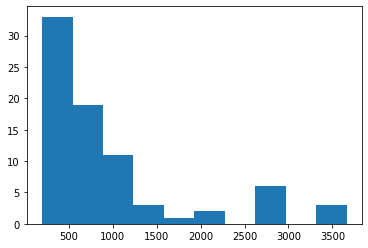

In [44]:
plt.hist(checks_active_df.query('grp == "A"').rev)

(array([ 91.,  59.,  17., 130.,   7.,   0.,   7.,   2.,   0.,   1.]),
 array([ 199. ,  644.1, 1089.2, 1534.3, 1979.4, 2424.5, 2869.6, 3314.7,
        3759.8, 4204.9, 4650. ]),
 <a list of 10 Patch objects>)

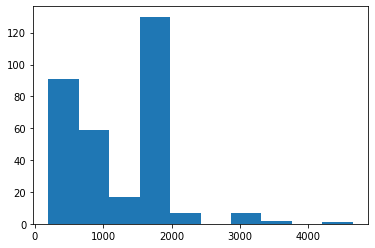

In [45]:
plt.hist(checks_active_df.query('grp == "B"').rev)

Переменные имеют не нормальное распределение, но выборка достаточно большая, необходимо проверить стат.значимость количественных данных в независимых выборках, поэтому будет использоваться t-критерий. 

In [48]:
stats.levene(checks_active_df.query('grp == "A"').rev, checks_active_df.query('grp == "B"').rev, center='mean')

LeveneResult(statistic=0.35109219559848354, pvalue=0.5538389015879754)

Тест Левена показывает, что дисперсии внутри групп примерно одинаковы, что также удовлетворяет условиям применения t-теста.

In [50]:
stats.ttest_ind(checks_active_df.query('grp == "A"').rev,
                checks_active_df.query('grp == "B"').rev)

Ttest_indResult(statistic=-3.1337795050930985, pvalue=0.0018562025265765867)

Статистивеская значимость различий между группами по метрике APRPU подтвердилась. Тестирование показало, что у целевой группы средний доход в расчёте на одного платящего пользователя вырос. 

**ВЫВОДЫ**:  
Несмотря на то, что результаты эксперимента не отразились на метрике конверсии в оплату, доходы от пользователей, использовавших новую механику оплаты, выросли, поэтому стоит запускать ее на всех пользователей.<br/> Возможно, результаты эксперимента не отразились на конверсии в оплату из-за того, что новая механика оплаты не видна до момента уже совершения оплаты. В то же время, возросший средий чек от платящего пользователя показывает, что нововведение возможно оказалось более удобным, что и приводит к увеличению дохода. 